#### library

In [46]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
import sys
from datetime import datetime, timedelta
from geopy.distance import great_circle

from sklearn.neighbors import KDTree, BallTree
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
import optuna
import catboost as cb

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

utils_directory = os.path.abspath('..')
sys.path.append(utils_directory)

import preprocessing

from utils.constant_utils import Directory
from utils import common_utils

import model
from inference import *

features_directory = os.path.abspath('../features')
sys.path.append(features_directory)

from clustering_features import *
from count_features import *
from distance_features import *
from other_features import *

#### data load

In [47]:
 print("Start the main.py successfully!")

'''
name : 실험자 이름입니다.
title : result 폴더에 저장될 실험명을 지정합니다.
'''
name = 'eun'
title = 'cluster,timefeature,categorical,drop,gangnam,xgb1000'

print("total data load ...")
df = common_utils.merge_data(Directory.train_data, Directory.test_data)

Start the main.py successfully!
total data load ...


In [48]:
### 클러스터 피처 apply
print("clustering apply ...")
for info_df_name in ['subway_info', 'school_info', 'park_info']:
    info_df = getattr(Directory, info_df_name)  
    df = clustering(df, info_df, feat_name=info_df_name, n_clusters=20)

### 이상치 처리
print("start to cleaning outliers...")
df = preprocessing.handle_age_outliers(df)

### 데이터 분할
print("train, valid, test split for preprocessing & feature engineering ...")
train_data_, valid_data_, test_data_ = common_utils.train_valid_test_split(df)


### 데이터 전처리
print("start to preprocessing...")
# type 카테고리화
train_data_ = preprocessing.numeric_to_categoric(train_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
valid_data_ = preprocessing.numeric_to_categoric(valid_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
test_data_ = preprocessing.numeric_to_categoric(test_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})

# 중복 제거
train_data_ = preprocessing.handle_duplicates(train_data_)
valid_data_ = preprocessing.handle_duplicates(valid_data_)

# 로그 변환
#df = preprocessing_fn.log_transform(df, 'deposit')


### 피처 엔지니어링
print("start to feature engineering...")
# clustering_feature
print("create clustering features")
train_data, valid_data, test_data = create_clustering_target(train_data_, valid_data_, test_data_)

# distance_features
print("create distance features")
train_data, valid_data, test_data = distance_gangnam(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_school_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = weighted_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)

# other_features
print("create other features")
train_data, valid_data, test_data = create_temporal_feature(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sin_cos_season(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_floor_area_interaction(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sum_park_area_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = shift_interest_rate_function(train_data, valid_data, test_data)
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'age')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'floor')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'area_m2')


# count_features
print("create count features")
train_data, valid_data, test_data = transaction_count_function(train_data, valid_data, test_data)
# 위의 함수를 바로 실행하기 위한 구조 : data/transaction_data에 train/valid/test_transaction_{month}.txt 구조의 파일이 있어야함
train_data, valid_data, test_data = create_subway_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_counts_within_radius_by_school_level(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_place_within_radius(train_data, valid_data, test_data)

clustering apply ...
start to cleaning outliers...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...
start to feature engineering...
create clustering features
create distance features
create other features
create count features
Loading pre-calculated transaction data for 3 months.


###### load and save

In [5]:
### data save
common_utils.save_and_load_function('train', 'save','level2-competitiveds-recsys-01/data', 'csv', train_data)
common_utils.save_and_load_function('valid', 'save','level2-competitiveds-recsys-01/data', 'csv', valid_data)
common_utils.save_and_load_function('test', 'save','level2-competitiveds-recsys-01/data', 'csv', test_data)

In [3]:
### data load
train_data = common_utils.save_and_load_function('train', 'load','level2-competitiveds-recsys-01/data', 'csv')
valid_data = common_utils.save_and_load_function('valid', 'load','level2-competitiveds-recsys-01/data', 'csv')
test_data = common_utils.save_and_load_function('test', 'load','level2-competitiveds-recsys-01/data', 'csv')

### modeling test

#### 개별 model

##### xgboost + feature importance + 상위 n개 importance로 한번 더 modeling  
(결과)   
validation score : 4706   
public score : 3684

In [8]:
print("standardization...")
train_data_, valid_data_, test_data_ = preprocessing.standardization(train_data, valid_data, test_data, scaling_type = 'standard')
# feature selection
train_data_scaled, valid_data_scaled, test_data_scaled = preprocessing.feature_selection(train_data_, valid_data_, test_data_)
# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_scaled, valid_data_scaled, test_data_scaled)

standardization...


In [9]:
model_ = model.xgboost(X_train, y_train)

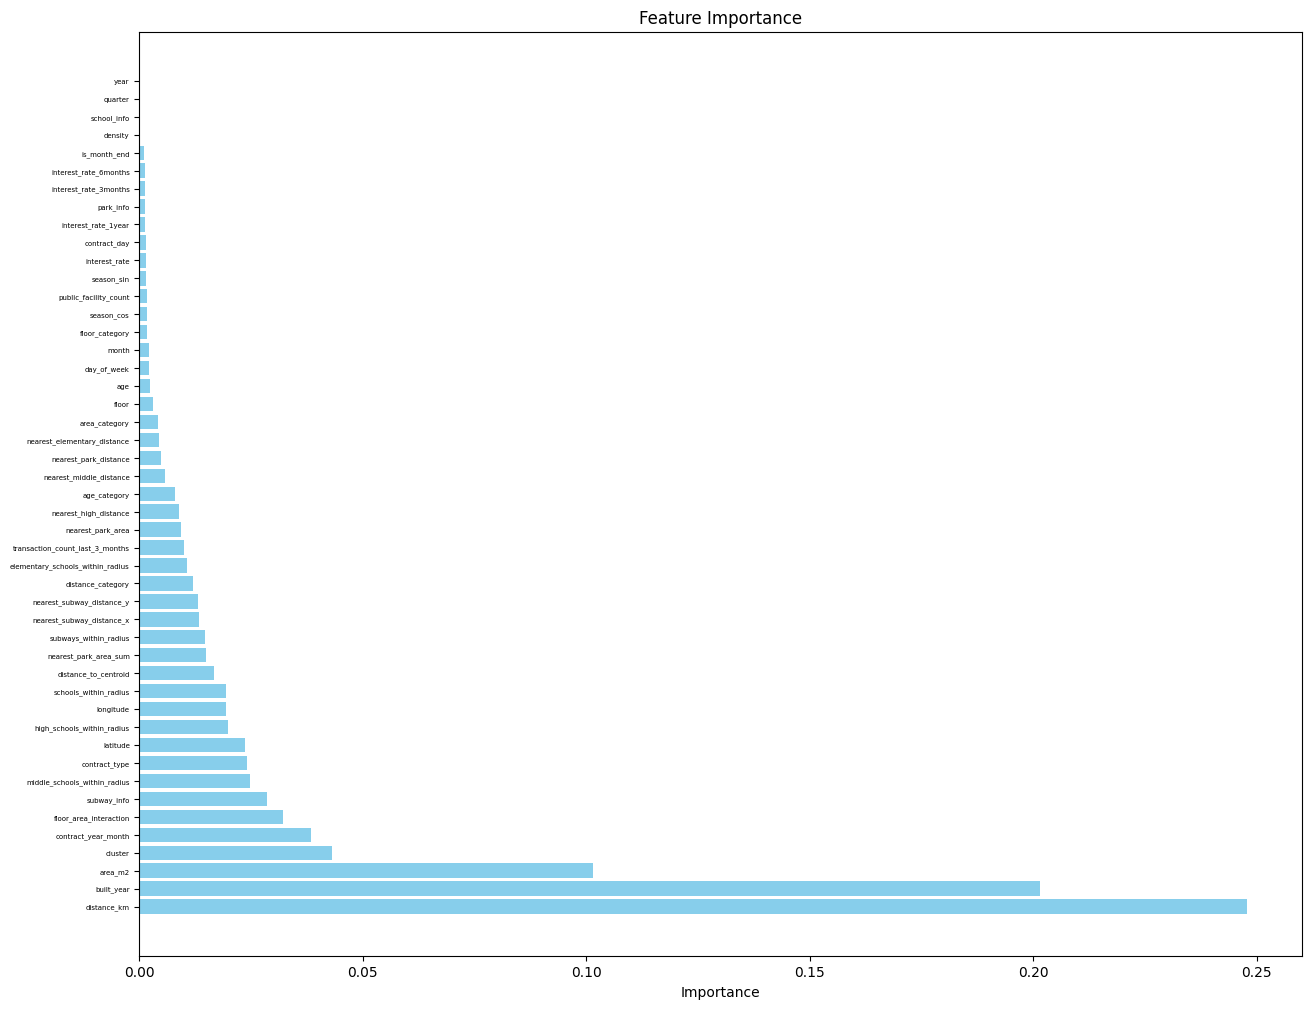

In [11]:
# Feature importance 추출
importance = model_.feature_importances_

# Feature importance를 DataFrame으로 변환
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Feature importance 시각화
plt.figure(figsize=(15, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.yticks(fontsize=8)
plt.title('Feature Importance')
plt.show()

In [ ]:
# 상위 n개에 대한 modeling 함수
def top_n_modeling(model_, train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame, top_n : int) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Feature importance 추출
    importance = model_.feature_importances_

    # Feature importance를 DataFrame으로 변환
    train_df = train_data_.copy()
    train_df = train_df.drop(columns = ['deposit'], axis=1)

    importance_df = pd.DataFrame({
        'Feature': train_df.columns,
        'Importance': importance
        }).sort_values(by='Importance', ascending=False)
    
    top_n_features = list(importance_df.head(top_n)['Features'].values)
    
    # feature split
    train_data_n = train_data_scaled[top_n_features + ['deposit']]
    valid_data_n = valid_data_scaled[top_n_features + ['deposit']]
    test_data_n = test_data_scaled[top_n_features]

    X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_n, valid_data_n, test_data_n)
    
    new_model = model.xgboost(X_train, y_train)
    prediction, mae = inference(new_model, 'validation', X_valid, y_valid)
    
    return prediction, mae

In [17]:
#### 상위 20개에 대한 데이터만 실험
top_20_features = list(importance_df.head(20)['Feature'].values)

In [27]:
top_20_features

['distance_km',
 'built_year',
 'area_m2',
 'cluster',
 'contract_year_month',
 'floor_area_interaction',
 'subway_info',
 'middle_schools_within_radius',
 'contract_type',
 'latitude',
 'high_schools_within_radius',
 'longitude',
 'schools_within_radius',
 'distance_to_centroid',
 'nearest_park_area_sum',
 'subways_within_radius',
 'nearest_subway_distance_x',
 'nearest_subway_distance_y',
 'distance_category',
 'elementary_schools_within_radius']

In [22]:
# feature split
train_data_20 = train_data_scaled[top_20_features + ['deposit']]
valid_data_20 = valid_data_scaled[top_20_features + ['deposit']]
test_data_20 = test_data_scaled[top_20_features]

X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_20, valid_data_20, test_data_20)

In [23]:
model_ = model.xgboost(X_train, y_train)
prediction, mae = inference(model_, 'validation', X_valid, y_valid)

validation Mae score
4377.878202392733


In [26]:
# record MAE score as csv
hyperparams = "learning_rate=0.3, n_estimators=1000, enable_categorical=True, random_state=Config.RANDOM_SEED"
# train with total dataset
print("Training with total dataset...")
X_total, y_total = common_utils.train_valid_concat(X_train, X_valid, y_train, y_valid)
model_ = model.xgboost(X_total, y_total)

# inference with test data
submission = inference(model_, 'submission', X_test)

# save sample submission
submission_path = os.path.join("/data/ephemeral/home/level2-competitiveds-recsys-01/", "submission")
os.makedirs(submission_path, exist_ok=True)
file_name = 'test_all_columns+xgboost'
file_name += '_' + time.strftime('%x', time.localtime())[:5].replace('/','') + '.csv'

submission_file_path = os.path.join(submission_path, 'test_all_columns+xgboost')
submission.to_csv(submission_file_path, index=False, encoding='utf-8-sig')

print("Successfully executed main.py.")

Training with total dataset...
Successfully executed main.py.


##### lightgbm + optuna

In [49]:
print("standardization...")
train_data_, valid_data_, test_data_ = preprocessing.standardization(train_data, valid_data, test_data, scaling_type = 'standard')
# feature selection
train_data_scaled, valid_data_scaled, test_data_scaled = preprocessing.feature_selection(train_data_, valid_data_, test_data_)
# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_scaled, valid_data_scaled, test_data_scaled)

standardization...


In [50]:
model_ = model.lightgbm(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4650
[LightGBM] [Info] Number of data points in the train set: 1515867, number of used features: 47
[LightGBM] [Info] Start training from score 37853.227009


In [51]:
# Feature importance 추출
importance = model_.feature_importances_

# Feature importance를 DataFrame으로 변환
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

#### 상위 20개에 대한 데이터만 실험
top_20_features = list(importance_df.head(20)['Feature'].values)

In [52]:
# feature split
train_data_20 = train_data_scaled[top_20_features + ['deposit']]
valid_data_20 = valid_data_scaled[top_20_features + ['deposit']]
test_data_20 = test_data_scaled[top_20_features]

X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_20, valid_data_20, test_data_20)

In [55]:
def objective(trial):
    # Define hyperparameters to tune
    params = {
        'objective': 'regression',  # 회귀 문제
        'metric': 'mae',            # 평가지표 설정
        'verbosity': -1,
        'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'max_depth': trial.suggest_int('max_depth', -1, 15),  # -1 means no limit
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 100.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 100.0),
    }

    # Create dataset for LightGBM
    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_valid, label=y_valid)

    # Train the model
    model = lgb.train(params, d_train, valid_sets=[d_valid])

    # Make predictions on validation set
    y_pred = model.predict(X_valid)

    # Calculate MAE
    mae = mean_absolute_error(y_valid, y_pred)
    return mae  # MAE가 최소가 되도록 최적화

# 2. Optimize hyperparameters with Optuna
study = optuna.create_study(direction='minimize')  # MAE를 최소화
study.optimize(objective, n_trials=50)  # 50 trials로 최적화

# 3. Get best parameters
best_params = study.best_params
print("Best hyperparameters:", best_params)


[I 2024-10-18 12:21:43,007] A new study created in memory with name: no-name-7d3ce1c6-4b4e-44c5-9825-3846c4b8e1eb
[I 2024-10-18 12:21:44,894] Trial 0 finished with value: 18297.391278110503 and parameters: {'learning_rate': 0.0012171099037940252, 'num_leaves': 54, 'max_depth': 1, 'min_data_in_leaf': 10, 'feature_fraction': 0.13495790531774726, 'bagging_fraction': 0.12382061184551843, 'bagging_freq': 1, 'lambda_l1': 11.921152860788792, 'lambda_l2': 0.37705656654079894}. Best is trial 0 with value: 18297.391278110503.
[I 2024-10-18 12:21:48,495] Trial 1 finished with value: 17556.074502555442 and parameters: {'learning_rate': 0.0010994840310124738, 'num_leaves': 217, 'max_depth': 6, 'min_data_in_leaf': 2, 'feature_fraction': 0.3350760906697563, 'bagging_fraction': 0.1846071977788742, 'bagging_freq': 7, 'lambda_l1': 0.2499352164215566, 'lambda_l2': 1.0305001181475896e-08}. Best is trial 1 with value: 17556.074502555442.
[I 2024-10-18 12:21:55,454] Trial 2 finished with value: 5451.4626242

Best hyperparameters: {'learning_rate': 0.2723494668638814, 'num_leaves': 231, 'max_depth': 9, 'min_data_in_leaf': 29, 'feature_fraction': 0.9079755050039745, 'bagging_fraction': 0.9357751970250049, 'bagging_freq': 2, 'lambda_l1': 0.0011705969585855099, 'lambda_l2': 10.854795619120951}


In [56]:
X_total, y_total = common_utils.train_valid_concat(X_train, X_valid, y_train, y_valid)
# 4. Train the final model with the best parameters on the full training set
final_model = lgb.LGBMRegressor(**best_params)  # 회귀 모델로 생성
final_model.fit(X_total, y_total)

# 5. Predict on the test set
y_test_pred = final_model.predict(X_test)
sample_submission = Directory.sample_submission
sample_submission['deposit'] = y_test_pred

# 결과 확인
submission_path = os.path.join("/data/ephemeral/home/level2-competitiveds-recsys-01/result/", "submission")
os.makedirs(submission_path, exist_ok=True)

file_name = 'lightgbm+optuna'
file_name += '_' + time.strftime('%x', time.localtime())[:5].replace('/','') + '.csv'

submission_file_path = os.path.join(submission_path, file_name)
sample_submission.to_csv(submission_file_path, index=False, encoding='utf-8-sig')

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.9079755050039745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9079755050039745
[LightGBM] [Warning] lambda_l2 is set=10.854795619120951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.854795619120951
[LightGBM] [Warning] lambda_l1 is set=0.0011705969585855099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011705969585855099
[LightGBM] [Warning] bagging_fraction is set=0.9357751970250049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9357751970250049
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.9079755050039745, colsample

#### ensemble

##### baseline model(lightGBM, xgboost, randomforest)
각각 3 모델에 대해 default parameter로 돌려본 뒤 각각의 feature importance를 찍어보고 좋은 feature를 탐색해보자

In [4]:
cate = ['contract_type','cluster','subway_info','park_info', 'school_info', 'distance_category','age_category', 'floor_category', 'area_category']
for column in cate:
    train_data[column] = train_data[column].astype('category')
    valid_data[column] = valid_data[column].astype('category')
    test_data[column] = test_data[column].astype('category')

In [5]:
print("standardization...")
train_data_, valid_data_, test_data_ = preprocessing.standardization(train_data, valid_data, test_data, scaling_type = 'standard')
train_data_scaled, valid_data_scaled, test_data_scaled = preprocessing.feature_selection(train_data_, valid_data_, test_data_)
# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_scaled, valid_data_scaled, test_data_scaled)

standardization...


In [6]:
## xgboost
print("Training with xgboost...")
xgb_model_ = model.xgboost(X_train, y_train)
xgb_prediction, xgb_mae = inference(xgb_model_, 'validation', X_valid, y_valid)


Training with xgboost...
validation Mae score
4701.579579631838


In [7]:
xgb_importance = xgb_model_.feature_importances_
        
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'features': train_df.columns,
    'importance': xgb_importance
}).sort_values(by='importance', ascending=False)
xgb_top_n_features = list(importance_df.head(20)['features'].values)
xgb_top_n_features

['distance_km',
 'built_year',
 'area_m2',
 'cluster',
 'contract_year_month',
 'floor_area_interaction',
 'subway_info',
 'middle_schools_within_radius',
 'contract_type',
 'latitude',
 'high_schools_within_radius',
 'longitude',
 'schools_within_radius',
 'distance_to_centroid',
 'nearest_park_area_sum',
 'subways_within_radius',
 'nearest_subway_distance_x',
 'nearest_subway_distance_y',
 'distance_category',
 'elementary_schools_within_radius']

In [8]:
print("Training with lightgbm...")
lgb_model_ = model.lightgbm(X_train, y_train)
lgb_prediction, lgb_mae = inference(lgb_model_, 'validation', X_valid, y_valid)

Training with lightgbm...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4650
[LightGBM] [Info] Number of data points in the train set: 1515867, number of used features: 47
[LightGBM] [Info] Start training from score 37853.227009
validation Mae score
5965.382795299795


In [9]:
lgb_importance = lgb_model_.feature_importances_
        
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'features': train_df.columns,
    'importance': lgb_importance
}).sort_values(by='importance', ascending=False)
lgb_top_n_features = list(importance_df.head(20)['features'].values)
lgb_top_n_features

['area_m2',
 'distance_km',
 'age_category',
 'cluster',
 'built_year',
 'contract_year_month',
 'latitude',
 'nearest_park_area_sum',
 'longitude',
 'distance_to_centroid',
 'contract_type',
 'transaction_count_last_3_months',
 'nearest_park_area',
 'floor_area_interaction',
 'nearest_subway_distance_x',
 'nearest_subway_distance_y',
 'nearest_park_distance',
 'subway_info',
 'elementary_schools_within_radius',
 'nearest_high_distance']

In [10]:
print("Training with catboost...")
cb_model_ = model.catboost(X_train, y_train)
cb_prediction, cb_mae = inference(xgb_model_, 'validation', X_valid, y_valid)

Training with catboost...
0:	learn: 16096.4659067	total: 915ms	remaining: 15m 13s
100:	learn: 6632.4534470	total: 1m 8s	remaining: 10m 6s
200:	learn: 5971.4520819	total: 2m 15s	remaining: 8m 56s
300:	learn: 5677.0274217	total: 3m 22s	remaining: 7m 50s
400:	learn: 5486.1226262	total: 4m 30s	remaining: 6m 44s
500:	learn: 5325.3304215	total: 5m 38s	remaining: 5m 37s
600:	learn: 5197.0774793	total: 6m 45s	remaining: 4m 29s
700:	learn: 5107.6023736	total: 7m 52s	remaining: 3m 21s
800:	learn: 5030.7075567	total: 8m 59s	remaining: 2m 14s
900:	learn: 4966.2277743	total: 10m 7s	remaining: 1m 6s
999:	learn: 4906.7199576	total: 11m 15s	remaining: 0us
validation Mae score
4701.579579631838


In [11]:
cb_importance = cb_model_.feature_importances_
        
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'features': train_df.columns,
    'importance': cb_importance
}).sort_values(by='importance', ascending=False)
cb_top_n_features = list(importance_df.head(20)['features'].values)
cb_top_n_features

['distance_km',
 'area_m2',
 'built_year',
 'contract_year_month',
 'cluster',
 'latitude',
 'contract_type',
 'longitude',
 'nearest_subway_distance_y',
 'distance_to_centroid',
 'transaction_count_last_3_months',
 'floor_area_interaction',
 'density',
 'nearest_park_area_sum',
 'nearest_subway_distance_x',
 'subway_info',
 'nearest_park_area',
 'high_schools_within_radius',
 'area_category',
 'age']

In [12]:
# Feature importance를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'features': train_df.columns,
    'lgb_importance': lgb_importance,
    'cb_importance': cb_importance,
    'xgb_importance': xgb_importance
})
importance_df[['lgb_importance','cb_importance','xgb_importance']] = importance_df[['lgb_importance','cb_importance','xgb_importance']].apply(lambda x: x / x.sum(), axis=0)

In [13]:
# MAE 기반 가중치 계산
weights = np.array([1 / lgb_mae, 1 / cb_mae, 1 / xgb_mae])
importance_df['weighted_importance'] = (
    importance_df['lgb_importance'] * weights[0] +
    importance_df['cb_importance'] * weights[1] +
    importance_df['xgb_importance'] * weights[2]
)

# 최종 feature importance 정렬 및 상위 20개 feature 선택
final_importance = importance_df.sort_values(by='weighted_importance', ascending=False).head(20)
final_importance

,features,lgb_importance,cb_importance,xgb_importance,weighted_importance
16,distance_km,0.101333,0.287911,0.247766,0.000131
0,area_m2,0.138000,0.248966,0.101441,0.000098
5,built_year,0.082333,0.119883,0.201569,0.000082
13,cluster,0.083000,0.031618,0.043184,0.000030
1,contract_year_month,0.056667,0.032407,0.038320,0.000025
37,age_category,0.100333,0.000474,0.008042,0.000019
6,latitude,0.043667,0.027406,0.023683,0.000018
7,longitude,0.039000,0.020189,0.019435,0.000015
3,contract_type,0.026667,0.020484,0.024164,0.000014
32,floor_area_interaction,0.020000,0.015536,0.032123,0.000013


##### baseline model + feature top20 + ensemble

###### voting ensemble

In [17]:
features = list(final_importance['features'].values)

print("standardization...")
train_data_, valid_data_, test_data_ = preprocessing.standardization(train_data, valid_data, test_data, scaling_type = 'standard')
train_data_scaled, valid_data_scaled, test_data_scaled = preprocessing.feature_selection(train_data_, valid_data_, test_data_)

train_data_scaled_f = train_data_scaled[features + ['deposit']]
valid_data_scaled_f = valid_data_scaled[features + ['deposit']]
test_data_scaled_f = test_data_scaled[features]

# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_scaled_f, valid_data_scaled_f, test_data_scaled_f)

standardization...


In [15]:
xgb_model_ = model.xgboost(X_train, y_train)
lgb_model_ = model.lightgbm(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3112
[LightGBM] [Info] Number of data points in the train set: 1515867, number of used features: 20
[LightGBM] [Info] Start training from score 37853.227009


In [31]:
cat_params = {'iterations': 1000,
              'learning_rate': 0.1,
              'depth': 6,
              'loss_function': 'MAE',
              'random_seed': 42,
              'cat_features' : ['cluster','age_category','contract_type','subway_info'],
              'verbose': 100}

cb_model_ = cb.CatBoostRegressor(**cat_params)

In [32]:
cb_model_.fit(X_train,y_train)

0:	learn: 16062.5785615	total: 509ms	remaining: 8m 28s
100:	learn: 6666.8320183	total: 40.2s	remaining: 5m 58s
200:	learn: 6011.8163837	total: 1m 19s	remaining: 5m 17s
300:	learn: 5694.5726935	total: 2m	remaining: 4m 39s
400:	learn: 5487.1838547	total: 2m 40s	remaining: 4m
500:	learn: 5349.7384726	total: 3m 20s	remaining: 3m 20s
600:	learn: 5230.7792478	total: 4m	remaining: 2m 39s
700:	learn: 5141.7336926	total: 4m 39s	remaining: 1m 59s
800:	learn: 5061.5936939	total: 5m 20s	remaining: 1m 19s
900:	learn: 5001.8673484	total: 6m	remaining: 39.6s
999:	learn: 4945.5969887	total: 6m 39s	remaining: 0us


In [33]:
# VotingRegressor로 앙상블
voting_ensemble = VotingRegressor(estimators=[
    ('xgb', xgb_model_),
    ('lgb', lgb_model_),
    ('cb', cb_model_)
])

voting_ensemble.fit(X_train, y_train)

ensemble_predictions = voting_ensemble.predict(X_valid)
ensemble_mae = mean_absolute_error(y_valid, ensemble_predictions)

print("Ensemble MAE:", ensemble_mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3112
[LightGBM] [Info] Number of data points in the train set: 1515867, number of used features: 20
[LightGBM] [Info] Start training from score 37853.227009
0:	learn: 16062.5785615	total: 461ms	remaining: 7m 40s
100:	learn: 6666.8320183	total: 39.9s	remaining: 5m 54s
200:	learn: 6011.8163837	total: 1m 20s	remaining: 5m 19s
300:	learn: 5694.5726935	total: 2m 1s	remaining: 4m 43s
400:	learn: 5487.1838547	total: 2m 42s	remaining: 4m 2s
500:	learn: 5349.7384726	total: 3m 22s	remaining: 3m 21s
600:	learn: 5230.7792478	total: 4m 2s	remaining: 2m 40s
700:	learn: 5141.7336926	total: 4m 41s	remaining: 2m
800:	learn: 5061.5936939	total: 5m 21s	remaining: 1m 19s
900:	learn: 5001.8673484	total: 6m 1s	remaining: 39.8s
999:	learn: 4945.5969887	total

In [41]:
# train with total dataset
print("Training with total dataset...")
X_total, y_total = common_utils.train_valid_concat(X_train, X_valid, y_train, y_valid)

# VotingRegressor로 앙상블
voting_ensemble = VotingRegressor(estimators=[
    ('xgb', xgb_model_),
    ('lgb', lgb_model_),
    ('cb', cb_model_)
])

voting_ensemble.fit(X_total, y_total)

ensemble_predictions = voting_ensemble.predict(X_test)
sample_submission = Directory.sample_submission
sample_submission['deposit'] = ensemble_predictions

Training with total dataset...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3118
[LightGBM] [Info] Number of data points in the train set: 1714416, number of used features: 20
[LightGBM] [Info] Start training from score 38207.326595
0:	learn: 16208.7052522	total: 518ms	remaining: 8m 37s
100:	learn: 6634.4973610	total: 45.7s	remaining: 6m 47s
200:	learn: 5985.4949807	total: 1m 30s	remaining: 5m 59s
300:	learn: 5651.6050489	total: 2m 16s	remaining: 5m 16s
400:	learn: 5454.2989698	total: 3m 1s	remaining: 4m 30s
500:	learn: 5305.4206254	total: 3m 47s	remaining: 3m 46s
600:	learn: 5190.2440325	total: 4m 33s	remaining: 3m 1s
700:	learn: 5098.9972331	total: 5m 18s	remaining: 2m 15s
800:	learn: 5014.3619231	total: 6m 3s	remaining: 1m 30s
900:	learn: 4952.6586869	total: 6m 49s	remaining: 44.9s
999:	learn: 4895.3883636	total: 7m 34s	remaining: 0us


NameError: name 'submission' is not defined

In [44]:
# save sample submission

submission_path = os.path.join("/data/ephemeral/home/level2-competitiveds-recsys-01/", "submission")
os.makedirs(submission_path, exist_ok=True)
file_name = "feature 20 + voting"
file_name += '_' + time.strftime('%x', time.localtime())[:5].replace('/','') + '.csv'

submission_file_path = os.path.join(submission_path, file_name)
sample_submission.to_csv(submission_file_path, index=False, encoding='utf-8-sig')

###### boosting ensemble

###### stacking ensemble

In [ ]:
features = list(final_importance['features'].values)

print("standardization...")
train_data_, valid_data_, test_data_ = preprocessing.standardization(train_data, valid_data, test_data, scaling_type = 'standard')
train_data_scaled, valid_data_scaled, test_data_scaled = preprocessing.feature_selection(train_data_, valid_data_, test_data_)

train_data_scaled_f = train_data_scaled[features + ['deposit']]
valid_data_scaled_f = valid_data_scaled[features + ['deposit']]
test_data_scaled_f = test_data_scaled[features]

# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_scaled_f, valid_data_scaled_f, test_data_scaled_f)

In [ ]:
xgb_model_ = model.xgboost(X_train, y_train)
lgb_model_ = model.lightgbm(X_train, y_train)

In [ ]:
cat_params = {'iterations': 1000,
              'learning_rate': 0.1,
              'depth': 6,
              'loss_function': 'MAE',
              'random_seed': 42,
              'cat_features' : ['cluster','age_category','contract_type','subway_info'],
              'verbose': 100}

cb_model_ = cb.CatBoostRegressor(**cat_params)

In [ ]:
# StackingRegressor 정의
stacking_ensemble = StackingRegressor(
    estimators=[
        ('xgb', xgb_model_),
        ('lgb', lgb_model_),
        ('cb', cb_model_)
    ],
    final_estimator=LinearRegression()  # 메타 모델로 사용할 모델
)

# 스태킹 모델 학습
stacking_ensemble.fit(X_train, y_train)

# 예측
stacking_predictions = stacking_ensemble.predict(X_valid)
stacking_mae = mean_absolute_error(y_valid, stacking_predictions)

print("Stacking Ensemble MAE:", stacking_mae)

##### rf

In [37]:
## random forest code(너무 오래걸림)
print("Training with randomforest...")
train_data_, valid_data_, test_data_ = preprocessing.standardization(train_data, valid_data, test_data, scaling_type = 'standard')
train_data_scaled_rf, valid_data_scaled_rf, test_data_scaled_rf = preprocessing.feature_selection(train_data_, valid_data_, test_data_)

Training with randomforest...


In [43]:
train_data_scaled_rf['contract_type'] = train_data_scaled_rf['contract_type'].replace({'unknown' : 0, 'new' : 1, 'renew' : 2})
valid_data_scaled_rf['contract_type'] = valid_data_scaled_rf['contract_type'].replace({'unknown' : 0, 'new' : 1, 'renew' : 2})
test_data_scaled_rf['contract_type'] = test_data_scaled_rf['contract_type'].replace({'unknown' : 0, 'new' : 1, 'renew' : 2})

train_data_scaled_rf['distance_category'] = train_data_scaled_rf['distance_category'].replace({'10km 초과' : 0, '5~10km 이내' : '1', '5km 이내' : '2'})
valid_data_scaled_rf['distance_category'] = valid_data_scaled_rf['distance_category'].replace({'10km 초과' : 0, '5~10km 이내' : '1', '5km 이내' : '2'})
test_data_scaled_rf['distance_category'] = test_data_scaled_rf['distance_category'].replace({'10km 초과' : 0, '5~10km 이내' : '1', '5km 이내' : '2'})

train_data_scaled_rf['age_category'] = train_data_scaled_rf['age_category'].replace({'Other' : '50'})
valid_data_scaled_rf['age_category'] = valid_data_scaled_rf['age_category'].replace({'Other' : '50'})
test_data_scaled_rf['age_category'] = test_data_scaled_rf['age_category'].replace({'Other' : '50'})


train_data_scaled_rf['floor_category'] = train_data_scaled_rf['floor_category'].replace({'25~30' : '27', 'Other' : '40'})
valid_data_scaled_rf['floor_category'] = valid_data_scaled_rf['floor_category'].replace({'25~30' : '27', 'Other' : '40'})
test_data_scaled_rf['floor_category'] = test_data_scaled_rf['floor_category'].replace({'25~30' : '27', 'Other' : '40'})

train_data_scaled_rf['area_category'] = train_data_scaled_rf['area_category'].replace({'60 under' : '60', '60~85' : '69', '85 over' : '88'})
valid_data_scaled_rf['area_category'] = valid_data_scaled_rf['area_category'].replace({'60 under' : '60', '60~85' : '69', '85 over' : '88'})
test_data_scaled_rf['area_category'] = test_data_scaled_rf['area_category'].replace({'60 under' : '60', '60~85' : '69', '85 over' : '88'})


In [ ]:
# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_scaled_rf, valid_data_scaled_rf, test_data_scaled_rf)

rf_model_ = model.randomforest(X_train, y_train)
rf_prediction, rf_mae = inference(rf_model_, 'validation', X_valid, y_valid)

In [ ]:
importance = rf_model_.feature_importances_
        
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'features': train_df.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)
rf_top_n_features = list(importance_df.head(20)['features'].values)
rf_top_n_features